# NTS Data




In [17]:
import random

from scipy.stats import norm
import numpy as np
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path

from caveat.evaluate.describe import features
from caveat.evaluate.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.evaluate.describe.transitions import sequence_prob_plot
from caveat.evaluate.distance import mape, emd
from caveat.evaluate.features import participation, times

In [34]:
attributes = pd.read_csv("../tmp/nts_home_attributes.csv")
schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
synth_path = Path("../toy_logs/nudged")

# kld0005 = pd.read_csv(
#     synth_path / "CVAESeqLSTM_6x6x512_kld0005/version_0/synthetic_schedules.csv"
# )
# kld005 = pd.read_csv(
#     synth_path / "CVAESeqLSTM_6x6x512_kld005/version_0/synthetic_schedules.csv"
# )
# kld05 = pd.read_csv(
#     synth_path / "CVAESeqLSTM_6x6x512_kld05/version_0/synthetic_schedules.csv"
# )
# kld1 = pd.read_csv(
#     synth_path / "CVAESeqLSTM_6x6x512_kld1/version_0/synthetic_schedules.csv"
# )

kld0005_nudge = pd.read_csv(
    synth_path
    / "CVAESeqLSTM_6x6x512_kld0005_nudge/version_0/synthetic_schedules.csv"
)
kld005_nudge = pd.read_csv(
    synth_path
    / "CVAESeqLSTM_6x6x512_kld005_nudge/version_0/synthetic_schedules.csv"
)
kld05_nudge = pd.read_csv(
    synth_path
    / "CVAESeqLSTM_6x6x512_kld05_nudge/version_0/synthetic_schedules.csv"
)
# kld1_nudge = pd.read_csv(
#     synth_path
#     / "CVAESeqLSTM_6x6x512_kld1_nudge/version_0/synthetic_schedules.csv"
# )

synthetic_attributes = pd.read_csv(
    synth_path
    / "CVAESeqLSTM_6x6x512_kld0005_nudge/version_0/synthetic_attributes.csv"
)

cvaes = {
    # "kld0005": kld0005,
    # "kld005": kld005,
    # "kld05": kld05,
    # "kld1": kld1,
    "kld0005_nudge": kld0005_nudge,
    "kld005_nudge": kld005_nudge,
    "kld05_nudge": kld05_nudge,
    # "kld1_nudge": kld1_nudge,
}


def age_group(age):
    if age < 17:
        return "child"

    elif age < 30:
        return "young adult"

    elif age < 65:
        return "adult"

    else:
        return "senior"


def fix_ethnicity(x):
    if x == "unknown":
        return "white"

    return x


def fix_car_access(x):
    if x == "unknown":
        return "yes"

    return x


def fix_children(x):
    if x > 2:
        return "3+"

    return str(x)


# income_groups = {1: "lowest", 2: "low", 3: "medium", 4: "high", 5: "highest"}

# attributes["age_group"] = attributes["age"].apply(age_group)
# attributes["income_group"] = attributes["income"].apply(
#     lambda x: income_groups[x]
# )
# attributes["ethnicity"] = attributes["ethnicity"].apply(fix_ethnicity)
# attributes["car_access"] = attributes["car_access"].apply(fix_car_access)
# attributes["hh_children"] = attributes["hh_children"].apply(fix_children)

In [35]:
attributes.work_status.value_counts()

work_status
employed      21269
unemployed    17583
student         998
Name: count, dtype: int64

In [36]:
synthetic_attributes.work_status.value_counts()

work_status
employed      21269
unemployed    17583
student         998
Name: count, dtype: int64

In [37]:
def filter_on(attributes, schedules, on):
    values = attributes[on].value_counts()
    selected = {}
    for value in values.index:
        pids = attributes[attributes[on] == value]["pid"]
        selected[value] = schedules[schedules["pid"].isin(pids)]
    return selected


def participation_table(schedules, groups):
    participation_rates = {
        ("observed", "all"): schedules.act.value_counts(normalize=True)
    }
    for name, group in groups.items():
        for key, data in group.items():
            participation_rates[(name, key)] = data.act.value_counts(
                normalize=True
            )

    return pd.DataFrame(participation_rates)


observed_work_status = filter_on(attributes, schedules, "work_status")
# kld0005_work_status = filter_on(synthetic_attributes, kld0005, "work_status")
# kld005_work_status = filter_on(synthetic_attributes, kld005, "work_status")
# kld05_work_status = filter_on(synthetic_attributes, kld05, "work_status")
# kld1_work_status = filter_on(synthetic_attributes, kld1, "work_status")
kld0005_work_status_nudge = filter_on(
    synthetic_attributes, kld0005_nudge, "work_status"
)
kld005_work_status_nudge = filter_on(
    synthetic_attributes, kld005_nudge, "work_status"
)
kld05_work_status_nudge = filter_on(
    synthetic_attributes, kld05_nudge, "work_status"
)
# kld1_work_status_nudge = filter_on(
#     synthetic_attributes, kld1_nudge, "work_status"
# )

work_status_groups = {
    "observed": observed_work_status,
    # "kld0005": kld0005_work_status,
    # "kld005": kld005_work_status,
    # "kld05": kld05_work_status,
    # "kld_1": kld1_work_status,
    "kld0005_nudge": kld0005_work_status_nudge,
    "kld005_nudge": kld005_work_status_nudge,
    "kld05_nudge": kld05_work_status_nudge,
    # "kld_1_nudge": kld1_work_status_nudge,
}

df = participation_table(schedules, work_status_groups).T
df["work"].unstack(-1)

,all,employed,student,unemployed
kld0005_nudge,NaN,0.062865,0.056078,0.063182
kld005_nudge,NaN,0.189125,0.182495,0.183156
kld05_nudge,NaN,0.018993,0.019920,0.018975
observed,0.069052,0.126750,0.015847,0.001159


In [38]:
df["other"].unstack(-1)

,all,employed,student,unemployed
kld0005_nudge,NaN,0.146017,0.150349,0.141894
kld005_nudge,NaN,0.128639,0.126506,0.123963
kld05_nudge,NaN,0.351470,0.341373,0.347866
observed,0.125155,0.105956,0.120172,0.148883


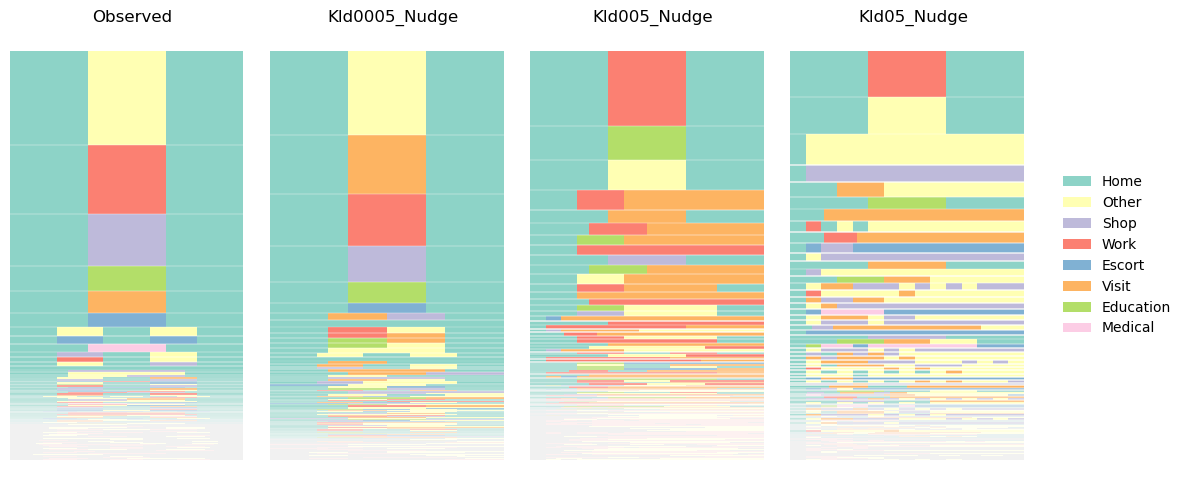

In [39]:
fig = sequence_prob_plot(schedules, cvaes)

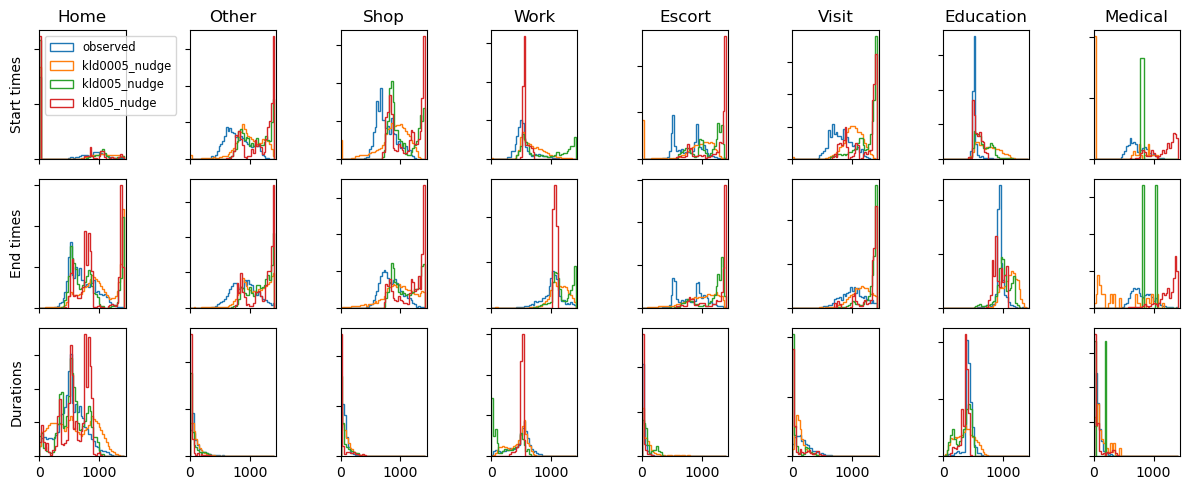

In [40]:
fig = times_distributions_plot(schedules, cvaes)

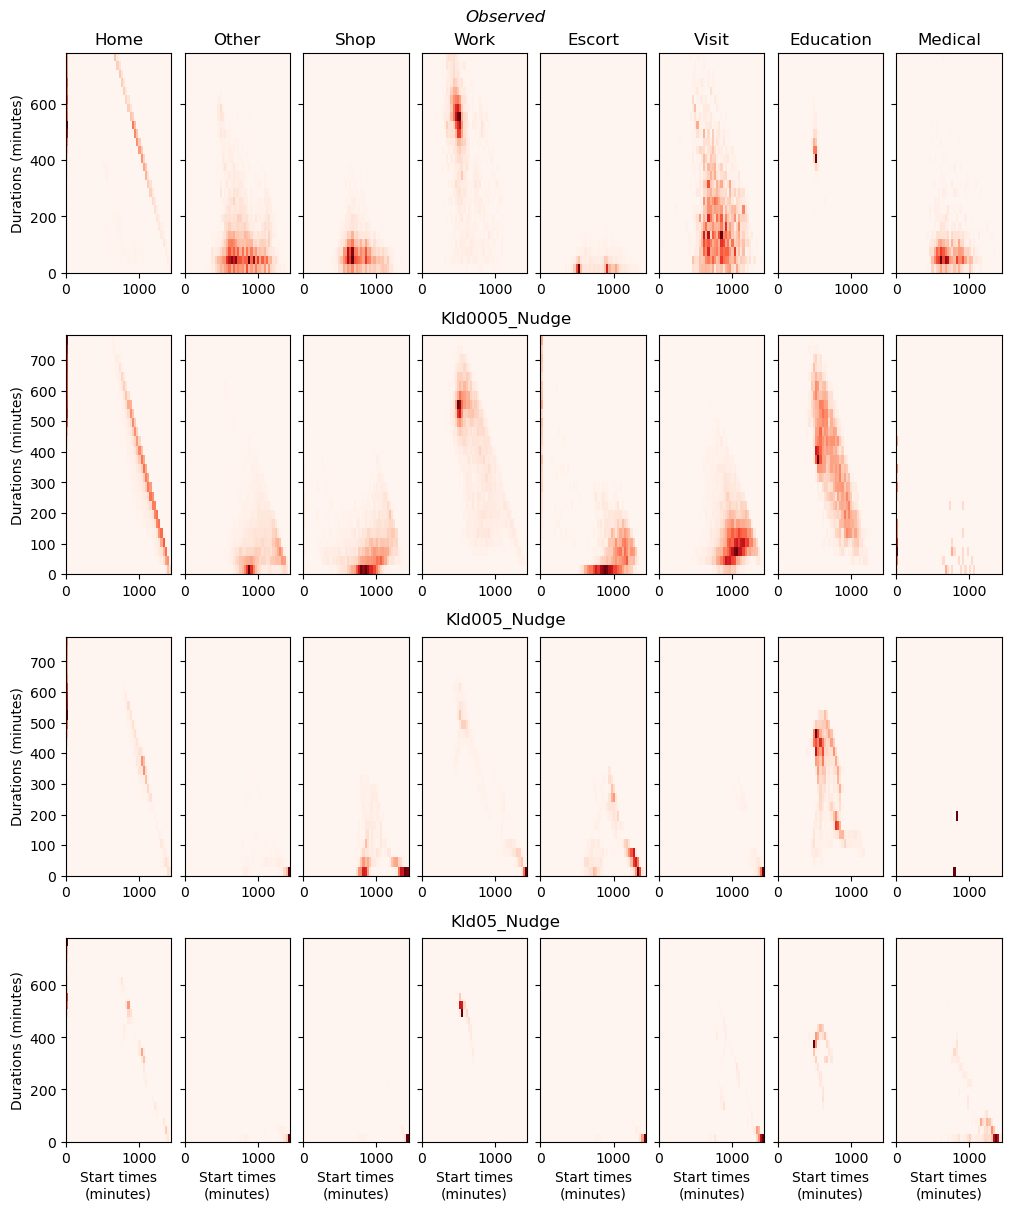

In [41]:
fig = joint_time_distributions_plot(schedules, cvaes, figsize=(10, 12))

In [42]:
inferred_zs = {}
in_attributes = {}
for name in [
    # "kld0005",
    # "kld005",
    # "kld05",
    # "kld1",
    "kld0005_nudge",
    "kld005_nudge",
    "kld05_nudge",
    # "kld1_nudge",
]:
    path = synth_path / f"CVAESeqLSTM_6x6x512_{name}/version_0/test_inference"
    inferred_z = pd.read_csv(path / "zs.csv", header=None)
    inferred_zs[name] = inferred_z
    in_attribute = pd.read_csv(path / "input_attributes.csv")
    in_attributes[name] = in_attribute
    print(name, len(inferred_z), len(in_attribute))

kld0005_nudge 3730 3730
kld005_nudge 3730 3730
kld05_nudge 3730 3730


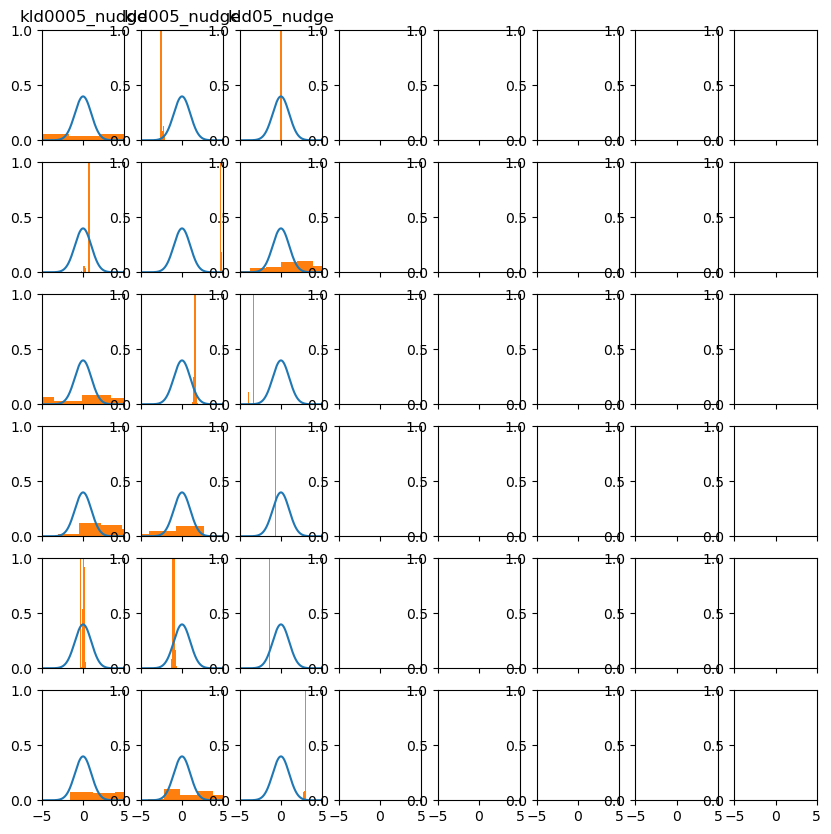

In [43]:
x_axis = np.arange(-10, 10, 0.001)
n = norm.pdf(x_axis, 0, 1)


def kld(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))


fig, axs = plt.subplots(6, 8, figsize=(10, 10), sharey=False, sharex=True)
for c, (name, data) in enumerate(inferred_zs.items()):
    axs[0, c].set_title(name)
    for i in range(6):
        axs[i, c].plot(x_axis, n)
        axs[i, c].hist(data.iloc[:, i], bins=20, density=True)
        axs[i, c].set_xlim((-5, 5))
        axs[i, c].set_ylim((0, 1))

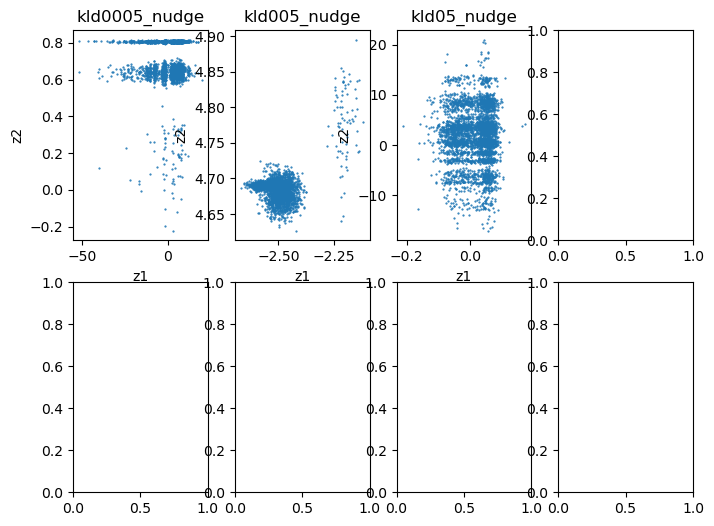

In [44]:
fig, axs = plt.subplots(2, 4, figsize=(8, 6))
for ax, (name, data) in zip(axs.flatten(), inferred_zs.items()):
    ax.set_title(name)
    ax.set_xlabel("z1")
    ax.set_ylabel("z2")
    ax.scatter(data.loc[:, 0], data.loc[:, 1], alpha=1, s=0.3)

In [45]:
for name, data in inferred_zs.items():
    print(f"{name}: {(data.corr().sum().sum()-6)/2}")

inferred_zs["kld1"].corr()

kld0005_nudge: 0.6708823278172917
kld005_nudge: 0.3902632715312855
kld05_nudge: 2.221950045110818


KeyError: 'kld1'

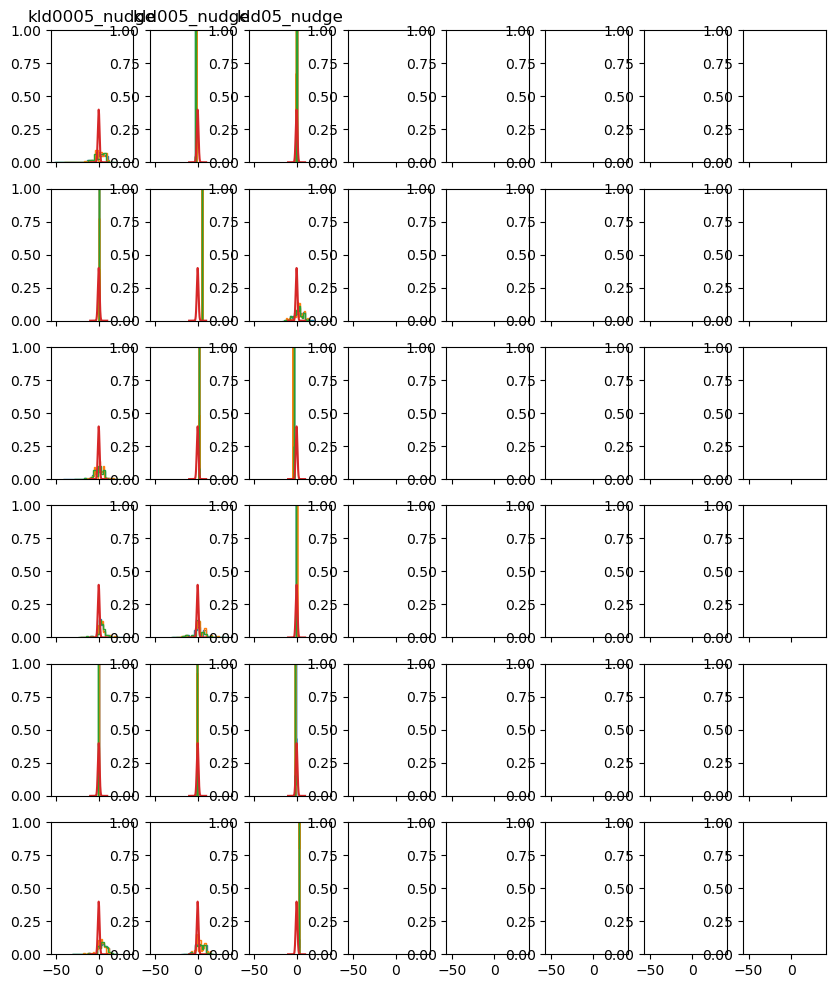

In [46]:
x_axis = np.arange(-10, 10, 0.001)
n = norm.pdf(x_axis, 0, 1)


def kld(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))


fig, axs = plt.subplots(6, 8, figsize=(10, 12), sharey=False, sharex=True)
for c, (name, data) in enumerate(inferred_zs.items()):
    data = data.copy()
    data["atts"] = in_attributes[name].work_status
    axs[0, c].set_title(name)
    for i in range(6):
        for j, group in data.groupby("atts"):
            axs[i, c].hist(group[i], bins=20, histtype="step", density=True)
        axs[i, c].plot(x_axis, n)
        # axs[i, c].set_xlim((-5, 5))
        axs[i, c].set_ylim((0, 1))

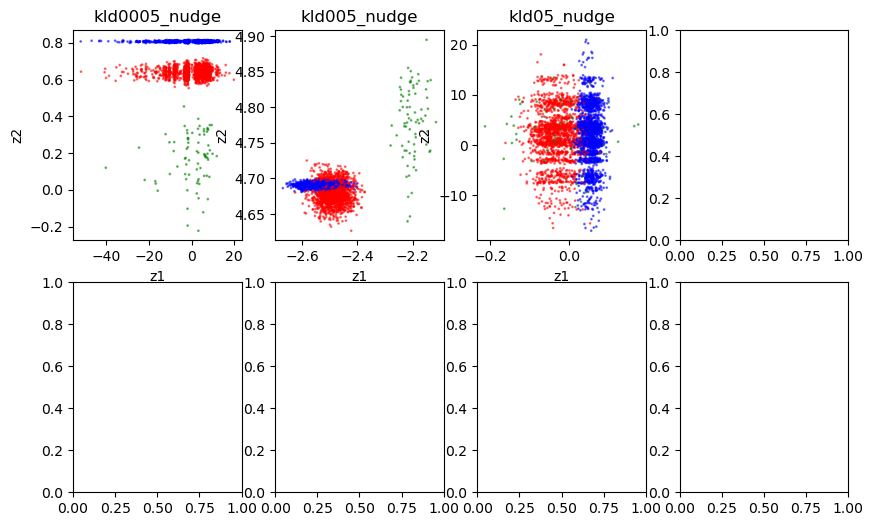

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6))
for ax, (name, data) in zip(axs.flatten(), inferred_zs.items()):
    atts = in_attributes[name]
    colors = list(
        atts.work_status.map(
            {"employed": "blue", "unemployed": "red", "student": "green"}
        )
    )
    ax.set_title(name)
    ax.set_xlabel("z1")
    ax.set_ylabel("z2")
    ax.scatter(data.loc[:, 0], data.loc[:, 1], alpha=0.5, s=1, c=colors)

In [32]:
import pickle

import pandas as pd
import torch
from pytorch_lightning import Trainer

from caveat import models
from caveat.data import build_custom_gen_dataloader


class Generator:
    def __init__(
        self, ckpt_path, schedule_encoder_path, attributes_encoder_path
    ) -> None:
        # load model from checkpoint
        self.model = models.sequence.cvae_sequence_lstm_all.CVAESeqLSTMAll.load_from_checkpoint(
            ckpt_path
        )

        # load encoders
        with open(schedule_encoder_path, "rb") as f:
            self.schedule_encoder = pickle.load(f)

        with open(attributes_encoder_path, "rb") as f:
            self.attributes_encoder = pickle.load(f)

        self.ckpt_path = ckpt_path
        self.trainer = Trainer()

    def __call__(self, synthetics):
        return self.gen(synthetics)

    # def gen(self, synthetics):
    #     return trim(stretch(pad(self._gen(synthetics))))

    def _gen(self, synthetics, z):
        synthetic_conditionals = self.attributes_encoder.encode(synthetics)

        dataloader = build_custom_gen_dataloader(
            synthetic_conditionals, z, max(len(synthetic_conditionals), 256)
        )

        res = self.trainer.predict(
            model=self.model, ckpt_path=self.ckpt_path, dataloaders=dataloader
        )
        ys, res, zs = zip(*res)

        schedules = self.schedule_encoder.decode(torch.concat(res))
        return schedules


synthetics = pd.DataFrame(
    [
        {"work_status": "employed"},
        {"work_status": "unemployed"},
        {"work_status": "student"},
    ]
)
zs = torch.Tensor([[-1] * 6] * 3)
gen_path = synth_path / "CVAESeqLSTM_6x6x512_kld001/version_0"
Generator(
    ckpt_path=gen_path / "checkpoints/epoch=30-step=2046.ckpt",
    schedule_encoder_path=gen_path / "schedule_encoder.pkl",
    attributes_encoder_path=gen_path / "attribute_encoder.pkl",
)._gen(synthetics, zs)

FileNotFoundError: [Errno 2] No such file or directory: 'c:/Users/fred/Projects/caveat/toy_logs/realistic_toy/CVAESeqLSTM_6x6x512_kld001/version_0/checkpoints/epoch=30-step=2046.ckpt'

In [ ]:
attributes.work_status.value_counts()

In [ ]:
data = inferred_zs["kld005"]
atts = in_attributes["kld005"]
colors = list(
    atts.work_status.map(
        {"employed": "blue", "unemployed": "red", "student": "yellow"}
    )
)
fig = ax.scatter(data.loc[:, 0], data.loc[:, 1], alpha=1, s=0.3, c=colors)

In [ ]:
observed_work_status["unemployed"].act.value_counts()

In [ ]:
kld1_work_status["unemployed"].act.value_counts()

In [ ]:
def split(attributes, schedules):
    splits = {}
    splits["gender"] = filter_on(attributes, schedules, "gender")
    splits["age"] = filter_on(attributes, schedules, "age_group")
    splits["age"] = {
        i: splits["age"][i] for i in ["senior", "adult", "young adult", "child"]
    }
    splits["ethnicity"] = filter_on(attributes, schedules, "ethnicity")
    splits["education"] = filter_on(attributes, schedules, "education")
    splits["license"] = filter_on(attributes, schedules, "license")
    splits["car_access"] = filter_on(attributes, schedules, "car_access")
    splits["work"] = filter_on(attributes, schedules, "work_status")
    splits["area"] = filter_on(attributes, schedules, "area")
    splits["income"] = filter_on(attributes, schedules, "income_group")
    splits["income"] = {
        i: splits["income"][i]
        for i in ["highest", "high", "medium", "low", "lowest"]
    }
    splits["hh"] = filter_on(attributes, schedules, "hh_composition")
    splits["children"] = filter_on(attributes, schedules, "hh_children")
    splits["children"] = {
        i: splits["children"][i] for i in ["0", "1", "2", "3+"]
    }
    return splits


observed_splits = split(attributes, schedules)
cvae_splits = split(attributes, cvae)
vae_splits = split(attributes, vae)
rnn_splits = split(attributes, rnn)
kld0_splits = split(attributes, kld0)
kld1_splits = split(attributes, kld1)
kld100_splits = split(attributes, kld100)

In [ ]:
build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        work_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    #   car_access_filtered, work_filtered, area_filtered, income_filtered],
    lambda x: features.average(times.start_times_by_act(x)),
)

In [ ]:
build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    lambda x: features.sd(times.start_times_by_act(x)),
)

In [ ]:
fig = times_distributions_plot(schedules, work_filtered)

In [ ]:
def plot_times(
    subs,
    column="start",
    acts=None,
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
):
    if acts is None:
        acts = set()
        for data in subs.values():
            acts.update(set(data.act))

    print("acts: ", acts)

    splits = {
        k: extract_activities(v, column, minimum, maximum)
        for k, v in subs.items()
    }
    print(splits.keys())

    return plot_bins(
        splits,
        acts,
        column,
        normalise=normalise,
        minimum=minimum,
        maximum=maximum,
        width=plot_width,
    )


def extract_activities(schedules, column, minimum, maximum):
    if schedules.empty:
        return pd.DataFrame()
    data = schedules.copy()
    if minimum is not None:
        data = data[data[column] >= minimum]
    if maximum is not None:
        data = data[data[column] <= maximum]
    return pd.DataFrame(
        {
            "act": data.act,
            "start": (data.start).astype(int),
            "end": (data.end).astype(int),
            "duration": (data.duration).astype(int),
        }
    )


def plot_bins(
    splits,
    acts,
    column,
    width=10,
    height_factor=1.2,
    normalise=False,
    minimum=0,
    maximum=1440,
):
    fig, axs = plt.subplots(
        len(acts),
        figsize=(width, len(acts) * (len(splits) + 1) / 4),
        sharex=False,
    )
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    mmhours = int(minimum / 60)
    mxhours = int(maximum / 60)
    duration = mxhours - mmhours
    step = 2

    for ax, act in zip(axs, acts):
        keys = list(splits.keys())
        n_keys = len(keys)
        binned = time_binner(splits, act, column, minimum, maximum)
        if normalise:
            binned = binned / binned.max()
        ax.pcolormesh(
            binned.T, cmap="gist_heat_r", edgecolors="white", linewidth=0.5
        )
        ax.xaxis.set_ticks([i for i in range(0, duration * 4 + 1, 8)])
        ax.set_xticklabels(
            [f"{h:02}:00" for h in range(mmhours, mxhours + 1, step)],
            size="small",
        )
        ax.yaxis.set_ticks([i + 0.5 for i in range(n_keys)])
        ax.yaxis.set_ticklabels(keys)
        ax.grid(which="minor", color="w", linestyle="-", linewidth=2)
        ax.tick_params(right=True, labelright=True)
        for pos in ["top", "bottom"]:
            ax.spines[pos].set_visible(False)
        ax.set_title(act.title(), fontsize="medium", rotation=0)

    fig.tight_layout()
    return fig


def time_binner(splits, act, column, minimum, maximum):
    """Bin start and end times and durations, return freq table for X hour period, 15min intervals."""
    bins = list(range(minimum, maximum + 1, 15))
    # bins[-1] = 100 * 60
    start = f"{int(minimum/60):02}:00:00"
    periods = int((maximum - minimum) / 15)
    labels = pd.timedelta_range(start=start, periods=periods, freq="15min")
    binned = pd.DataFrame(
        index=pd.timedelta_range(start=start, periods=periods, freq="15min")
    )
    for key, data in splits.items():
        if data.empty:
            continue
        split = data[data.act == act]
        if len(split) == 0:
            continue
        binned[key] = pd.cut(
            split[column], bins, labels=labels, right=False
        ).value_counts()

    return binned


def plot_times_compare(
    splits,
    column="start",
    acts=None,
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
):
    if acts is None:
        acts = set()
        for k, split in splits.items():
            for i, data in split.items():
                if data.empty:
                    continue
                acts.update(set(data.act))

    print("acts: ", acts)

    processed_splits = {}
    for name, split in splits.items():
        processed_splits[name] = {
            k: extract_activities(v, column, minimum, maximum)
            for k, v in split.items()
        }
    print(splits.keys())

    return plot_bins_compare(
        splits,
        acts,
        column,
        normalise=normalise,
        minimum=minimum,
        maximum=maximum,
        width=plot_width,
    )


def plot_bins_compare(
    splits,
    acts,
    column,
    width=10,
    height_factor=1.2,
    normalise=False,
    minimum=0,
    maximum=1440,
):
    fig = plt.figure(
        # constrained_layout=True,
        figsize=(width, len(acts) * (len(splits) + 1) * len(splits) / 4)
    )

    subfigs = fig.subfigures(len(acts), 1)
    mmhours = int(minimum / 60)
    mxhours = int(maximum / 60)
    duration = mxhours - mmhours
    step = 2

    for act, subfig in zip(acts, subfigs.flat):
        # subfig.suptitle(f'Subfig {outerind}')
        axs = subfig.subplots(len(splits), 1)
        for name, split, ax in zip(splits.keys(), splits.values(), axs.flat):
            ax.set_title(f"{name} {act}")
            keys = list(split.keys())
            n_keys = len(keys)
            binned = time_binner(split, act, column, minimum, maximum)
            if normalise:
                binned = binned / binned.max()
            ax.pcolormesh(
                binned.T, cmap="gist_heat_r", edgecolors="white", linewidth=0.5
            )
            ax.set_xticks([])
            ax.yaxis.set_ticks([i + 0.5 for i in range(n_keys)])
            ax.yaxis.set_ticklabels(keys)
            ax.grid(which="minor", color="w", linestyle="-", linewidth=2)
            ax.tick_params(right=True, labelright=True)
            for pos in ["top", "bottom"]:
                ax.spines[pos].set_visible(False)
            # ax.set_title(act.title(), fontsize="medium", rotation=0)
        ax.xaxis.set_ticks([i for i in range(0, duration * 4 + 1, 8)])
        ax.set_xticklabels(
            [f"{h:02}:00" for h in range(mmhours, mxhours + 1, step)],
            size="small",
        )

    # fig.tight_layout()
    return fig


fig = plot_times_compare(
    splits={
        "obs": observed_splits["work"],
        "kld0": kld0_splits["work"],
        "kld1": kld1_splits["work"],
    },
    acts=["home", "shop"],
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

In [ ]:
fig = plot_times_compare(
    splits={
        "obs": observed_splits["age"],
        "KLD1": KLD1_splits["age"],
        "KLD100": KLD100_splits["age"],
        "KLD10000": KLD10000_splits["age"],
    },
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

In [ ]:
fig = plot_times(
    observed_splits["work"],
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

In [ ]:
fig = plot_times(
    children_filtered,
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

In [ ]:
op = lambda x: features.average(participation.participation_rates_by_act(x))

build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    op,
)

In [ ]:
fig = sequence_prob_plot(schedules, observed_splits["age"], figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(cvae, cvae_splits["work"], figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(schedules, education_filtered, figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(schedules, income_filtered, figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(schedules, area_filtered, figsize=(12, 4))

In [ ]:
fig = joint_time_distributions_plot(schedules, gender_filtered, figsize=(10, 6))

In [ ]:
fig = joint_time_distributions_plot(schedules, age_filtered, figsize=(10, 8))